# User behavior in health tracking app

### Data sources:
#### Subset of data which only has users who inputed their weight at least 2x. However, there are still null or zero values.
- stats.txt contains each user's app attributes
- weights.txt contains multiple weight entries for each user ID

#### In order to understand how the app is serving the users, we need input from the user. In this data, we are looking for:
- number of times the user inputs their weight (goal tracking)
- when they input their weight: frequency, when they started tracking compared to when the app was installed
- what other factors influence if they goal track or reach their goal i.e. who reaches their goals?

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Import pickle file (cleaned)

In [2]:
# this file incorporates the following changes to original table:
# - dates to datetime objects
# - Gender 'none' to None

df = pd.read_pickle('df_190419.pkl')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86796 entries, 0 to 86795
Data columns (total 26 columns):
ID                              86796 non-null int64
InstallDate                     86796 non-null datetime64[ns]
LastSavedUTC                    74717 non-null datetime64[ns]
FirstInstalledVersion           86785 non-null object
SessionCount                    86796 non-null int64
UICulture                       86796 non-null object
Language                        86796 non-null object
IsPaid                          86796 non-null bool
LastPurchaseDaysSinceInstall    3961 non-null float64
Feedback.FirstRating            37542 non-null float64
Feedback.RatingCount            54386 non-null float64
Gender                          86796 non-null object
AgeWhenGoalsSet                 86796 non-null int64
DailyGoalCount                  86796 non-null int64
Program                         86796 non-null object
ReminderFrequency               86796 non-null object
SelectedTotal  

### Overall correlation between features

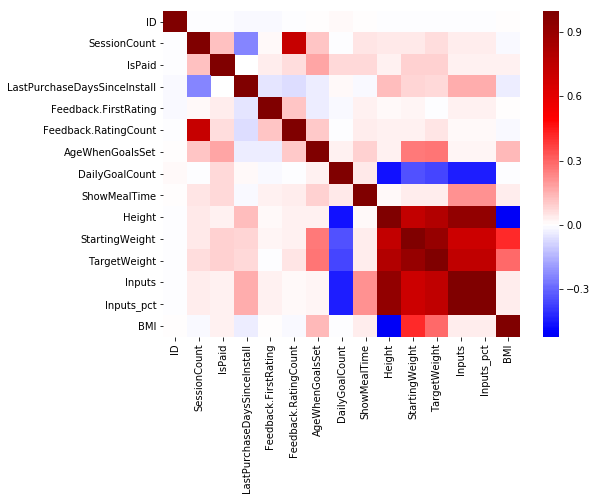

In [6]:
# Correlation plot for all features

plt.figure(figsize = (8,6))
sns.heatmap(df.corr(), cmap='seismic', center=0)

This heatmap provides a starting point to see what correlations between features might lie in the data and gives us a sense of what questions to ask and where to probe further. 

Some correlations are not surprising, or even expected: 
- The number of times the user uses the app (SessionCount) is positively correlated to the number of times the user's feedback rating on the app is requested (Feedback.FirstRating) 
- Age, weight, and height are positively correlated (AgeWhenGoalsSet, StartingWeight, Height)

Some interesting things to explore further:
- Older users are more likely to pay for the app (AgeWhenGoalsSet, IsPaid). They tend to have more disposable income. Or is it because the app is geared more towards an older age group? We can look at the differences in app usage for different age brackets.
- Number of daily goals (DailyGoalCount) is strongly, negatively correlated to height and weight, but not age. What's going on here? Likely that the distributions of these features are opposite of each other- plot these to see.

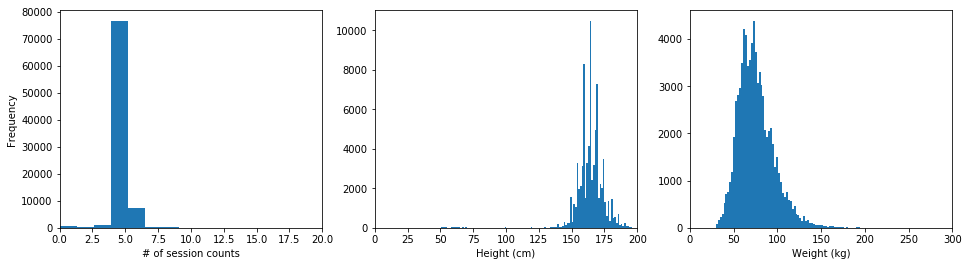

In [34]:
plt.figure(1, figsize=(16,4))
plt.subplot(131)
plt.hist(df['DailyGoalCount'], bins=30)
plt.xlim(0,20)
plt.xlabel('# of session counts')
plt.ylabel('Frequency')

plt.subplot(132)
plt.hist(df[df['Height']>0]['Height'], bins=200)
plt.xlim(0,200)
plt.xlabel('Height (cm)')

plt.subplot(133)
plt.hist(df[df['StartingWeight']>0]['StartingWeight'], bins=200)
plt.xlim(0,300)
plt.xlabel('Weight (kg)')
plt.show()

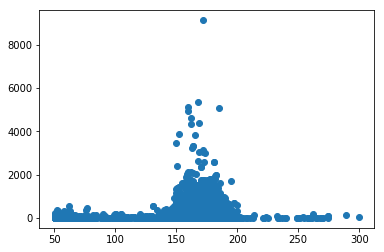

In [43]:
df1 = df[df['Height']>0]

plt.scatter(df1['Height'], df1['SessionCount'])
plt.show()

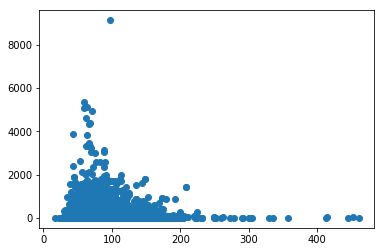

In [44]:
df2 = df[df['StartingWeight']>0]

plt.scatter(df2['StartingWeight'], df2['SessionCount'])
plt.show()

### SessionCount

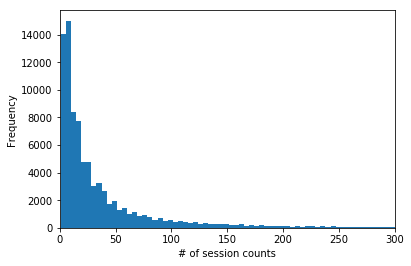

In [10]:
plt.hist(df['SessionCount'], bins=2000)
plt.xlim(0,300)
plt.xlabel('# of session counts')
plt.ylabel('Frequency')
plt.show()

### UICulture
Note conversion rates for each country are ~10x higher in this group compared to general user population

In [13]:
top50_cultures = df['UICulture'].value_counts().head(50).index.tolist()
pivot_UICulture = pd.pivot_table(df[df['UICulture'].isin(top50_cultures)], index='UICulture', values='IsPaid', aggfunc=('count','mean'))

In [14]:
# Sort count by highest count descending
pivot_UICulture = pivot_UICulture.reindex(pivot_UICulture['count'].sort_values(ascending=False).index)
# Change mean into percentage
pivot_UICulture['mean'] = (pivot_UICulture['mean'].round(decimals=4))*100
pivot_UICulture.columns= ['# installs', 'conversion rate']

In [15]:
pivot_UICulture

,# installs,conversion rate
UICulture,,
ru-RU,17692,3.11
pt-BR,6622,1.92
de-DE,5532,6.91
ro-RO,4514,5.01
en-US,4328,7.65
it-IT,4299,5.28
fr-FR,3670,4.47
pl-PL,3355,3.49
el-GR,2304,2.17


### IsPaid: number of people who paid for app

In [16]:
df['IsPaid'].value_counts()

False    82835
True      3961
Name: IsPaid, dtype: int64

In [17]:
print('conversion rate: {0:.2f}%'.format(3961/82835*100))

conversion rate: 4.78%


Compared to the general user population, this group (users who input weight 2x or more) are __24 times more likely to pay__ for an app subscription (4.78% vs 0.2% conversion).

## Gender and age

In [14]:
df['Gender'].value_counts()

Female    69717
Male       9648
None       7431
Name: Gender, dtype: int64

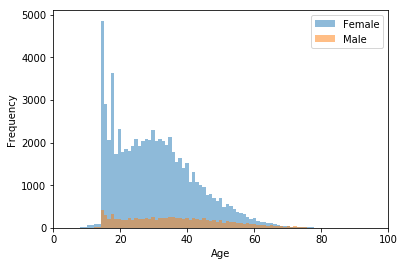

In [20]:
a = df[df['Gender']=='Female']['AgeWhenGoalsSet']
b = df[df['Gender']=='Male']['AgeWhenGoalsSet']

bins = np.linspace(0,100,100)

plt.hist(a, bins, alpha=0.5, label='Female')
plt.hist(b, bins, alpha=0.5, label='Male')
plt.legend(loc='upper right')
plt.xlim(0,100)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

## Who is more likely to engage in the app (based on # of inputs and session count)?